In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from scipy.stats import skew, kurtosis

torch.cuda.empty_cache()
# imports of custom blocks for model, data generation
from Ferret.ImplicitAm import ImplicitAmBre, ImplicitAmBer
from create_plots import *
from models import *
from utils import AmericanCallData, get_prices_call
from utils import S, T, K, RISK_FREE, SIGMA, S_MAX

## Call Option

### Content: 
1. **Generating Data**
2. **Training on Generated Data, Testing Both on Generated and Real Data**
3. **Training on Real Data, Testing on Real Data**
4. **Mixture of Data (70/30, 50/50), Testing on Real Data**


In [ ]:
call_data = AmericanCallData(t_range=T, S_range=S, K=K, r=RISK_FREE, sigma=SIGMA)
# N_ivp - IVP points
# N_bvp - both BVP1 and BVP2 points
# N_col - colocation points
X = call_data.initialize_data(N_ivp=1000, N_bvp=3000, N_col=6000, is_call=True)
option = ImplicitAmBer(
    S[0],
    K,
    RISK_FREE,
    T[1],
    SIGMA,
    S_MAX,
    M=400,  # S
    N=365 * 3,  # t
    is_call=False,
)
option.price()
option_fde_prices = option.grid
data = get_prices_call(X, option_fde_prices, generated=True)
df = pd.DataFrame(
    data=data,
    columns=[
        "TimeToExp",
        "UnderlyingPrice",
        "TargetPrice",
        "OpenInterest",
        "Delta",
        "Gamma",
        "Theta",
        "Vega",
        "BSAprox",
    ],
)
df[["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]] = df[
    ["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]
].round(2)
df["OpenInterest"] = df["OpenInterest"].round(0)
df.to_csv("../train_data/generated_call.csv")

In [2]:
df = pd.read_csv("../train_data/generated_call.csv",index_col=0)
print(df.shape)
df.head()

(10000, 9)


,TimeToExp,UnderlyingPrice,TargetPrice,OpenInterest,Delta,Gamma,Theta,Vega,BSAprox
0,850.0,122.12,43.00,364.0,0.345992,0.144298,-3.575622,2.522842,31.500
1,311.0,186.19,29.31,514.0,0.167115,0.056784,-2.531811,6.822075,24.655
2,629.0,52.52,69.69,65.0,0.376269,0.272558,-7.814967,5.852912,0.000
3,469.0,144.80,37.75,58.0,0.009575,0.017516,-1.451383,1.604901,0.000
4,0.0,187.07,29.12,91.0,0.441506,0.138325,-8.777276,5.934998,118.970


In [3]:
# Check for ITM and OTM
print(f"ITM count:{np.sum(df.UnderlyingPrice > K)}")
print(f"OTM count:{np.sum(df.UnderlyingPrice <= K)}")

ITM count:4201
OTM count:5799


In [4]:
df_real = pd.read_csv("../train_data/call_df.csv", index_col=0)
print(df_real.shape)
# Check for ITM and OTM
print(f"ITM count:{np.sum(df_real.UnderlyingPrice > K)}")
print(f"OTM count:{np.sum(df_real.UnderlyingPrice <= K)}")

(223217, 11)
ITM count:57430
OTM count:165787


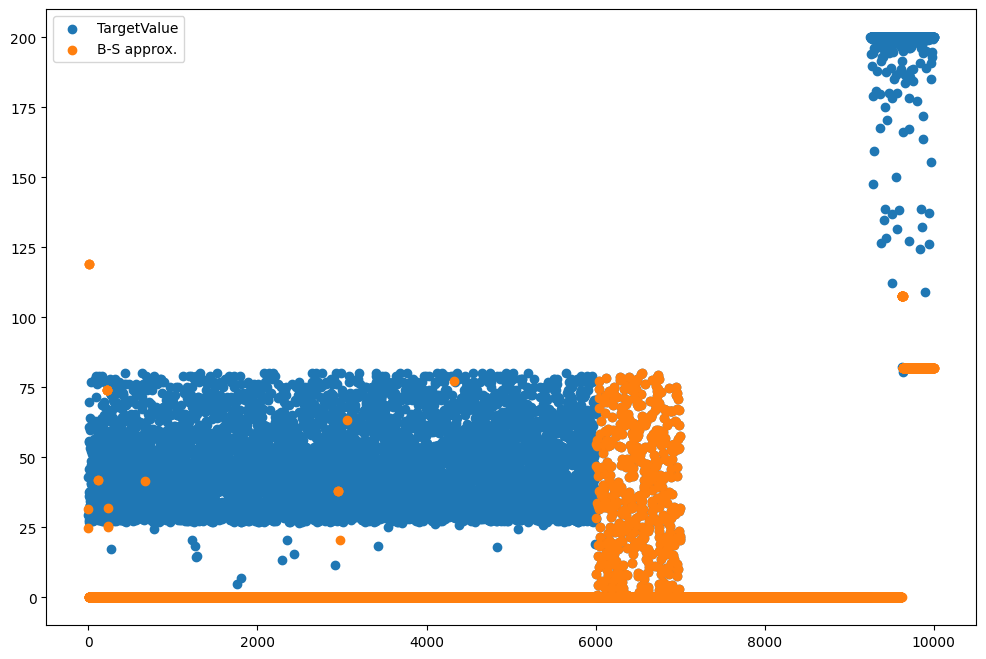

In [30]:
plt.figure(figsize=(12, 8))
plt.scatter(
    x=np.arange(1, len(df.TargetPrice) + 1, 1), y=df.TargetPrice, label="TargetValue"
)
plt.scatter(x=np.arange(1, len(df.BSAprox) + 1, 1), y=df.BSAprox, label="B-S approx.")
plt.legend()
plt.show()

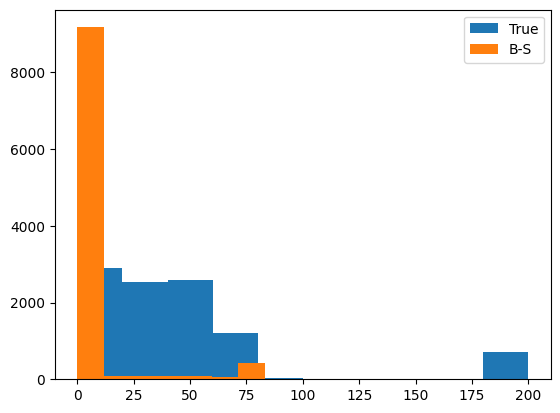

In [5]:
plt.hist(df.TargetPrice, label="Target value")
plt.hist(df.BSAprox, label="B-S")
plt.legend()
plt.show()

In [ ]:
# adding BSAprox column to real data
# Run it once, only if u dont have saved df
df_real = get_prices_call(df_real.to_numpy(), generated=False)
df_real = pd.DataFrame(
    data=df_real,
    columns=[
        [
            "UnderlyingPrice",
            "Type",
            "Strike",
            "OpenInterest",
            "IV",
            "Delta",
            "Gamma",
            "Theta",
            "Vega",
            "Time",
            "TargetPrice",
            "BSAprox",
        ]
    ],
)

df_real["BSAprox"] = df_real["BSAprox"].round(2)
df_real.to_csv("../train_data/call_df_with_approx.csv")

In [2]:
# df_real["BSAprox"] = df_real["BSAprox"].round(2)
# df_real.to_csv("../train_data/call_df_with_approx.csv")
df_real = pd.read_csv("../train_data/call_df_with_approx.csv", index_col=0)
df_real.head()

,UnderlyingPrice,Type,Strike,OpenInterest,IV,Delta,Gamma,Theta,Vega,Time,TargetPrice,BSAprox
0,71.11,call,55.0,0,0.2693,1.0000,0.0000,-1.2654,0.0015,21,16.08,16.11
1,71.11,call,60.0,3,0.2693,0.9968,0.0022,-1.7664,0.1636,21,11.38,11.11
2,71.11,call,62.5,9,0.2693,0.9813,0.0101,-3.2537,0.7659,21,8.50,8.61
3,71.11,call,65.0,16,0.2693,0.9286,0.0302,-6.9022,2.2884,21,6.98,6.11
4,71.11,call,67.5,44,0.2430,0.8313,0.0617,-10.4813,4.2260,21,4.10,3.61


In [3]:
# hyperparams for training
N_EPOCH = 20
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 5e-4
HIDDEN_LAYER = 20
HIDDEN_WIDTH = 64
EXPERIMENT_NAME = "exp_call_8_gen"
MODEL_TYPE = AmericanPut_gated3
experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [4]:
import logging
from datetime import datetime

logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode="w")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# torch.set_default_device(DEVICE)
logging.info(f"Running on device={DEVICE}")

cuda


In [6]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [8]:
# df = df_real.sample(n=20000, random_state=42)
df_train, df_val = train_test_split(df, test_size=0.2)
print(df_train.shape)
print(df_val.shape)

(8000, 9)
(2000, 9)


In [9]:
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = 1 / len(df_val) * np.sum((df_val.TargetPrice - df_val.BSAprox) ** 2)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)

In [10]:
train_df = CustomDataset(df_train)
val_df = CustomDataset(df_val)

In [11]:
# import torch.multiprocessing as mp
from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Set the multiprocessing start method to 'spawn'
# mp.set_start_method("spawn", force=True)
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=128,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    val_df,
    batch_size=64,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "SGD": torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.7),
    "RMSprop": torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE),
    "Adam": torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
    "Adamax": torch.optim.Adamax(
        model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.99)
    ),
}
criteriation = nn.MSELoss()

In [12]:
def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step(np.mean(train_losses))  # Step the scheduler based on training loss
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, verbose=True)

    for i in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}"
        )

In [13]:
train_loss_dict = {}
val_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, val_loss_dict)

Optimizer: SGD


100%|██████████| 32/32 [00:00<00:00, 303.22it/s]

Epoch 1, train loss: 3747.9929, test loss: 1851.1812



100%|██████████| 32/32 [00:00<00:00, 310.76it/s]

Epoch 2, train loss: 1859.7703, test loss: 1835.4846



100%|██████████| 32/32 [00:00<00:00, 284.55it/s]

Epoch 3, train loss: 1881.7311, test loss: 1788.4981



100%|██████████| 32/32 [00:00<00:00, 269.95it/s]

Epoch 4, train loss: 1886.7805, test loss: 1930.8290



100%|██████████| 32/32 [00:00<00:00, 277.30it/s]

Epoch 5, train loss: 1893.3125, test loss: 1823.6839



100%|██████████| 32/32 [00:00<00:00, 330.74it/s]

Epoch 6, train loss: 1860.1268, test loss: 1862.0781



100%|██████████| 32/32 [00:00<00:00, 297.72it/s]

Epoch 7, train loss: 1874.0215, test loss: 1793.9234



100%|██████████| 63/63 [00:00<00:00, 148.11it/s]

Epoch 00008: reducing learning rate of group 0 to 5.0000e-05.



100%|██████████| 32/32 [00:00<00:00, 299.89it/s]

Epoch 8, train loss: 1875.2155, test loss: 1794.8601



100%|██████████| 32/32 [00:00<00:00, 327.07it/s]

Epoch 9, train loss: 1829.9320, test loss: 1764.0046



100%|██████████| 32/32 [00:00<00:00, 283.25it/s]

Epoch 10, train loss: 1808.7738, test loss: 1758.4304



100%|██████████| 32/32 [00:00<00:00, 237.99it/s]

Epoch 11, train loss: 1810.6006, test loss: 1758.8459



100%|██████████| 32/32 [00:00<00:00, 328.47it/s]

Epoch 12, train loss: 1805.2599, test loss: 1751.2096



100%|██████████| 32/32 [00:00<00:00, 272.82it/s]

Epoch 13, train loss: 1809.8811, test loss: 1763.3051



100%|██████████| 32/32 [00:00<00:00, 298.39it/s]

Epoch 14, train loss: 1801.6558, test loss: 1753.0307



100%|██████████| 32/32 [00:00<00:00, 305.93it/s]

Epoch 15, train loss: 1796.2809, test loss: 1753.3098



100%|██████████| 32/32 [00:00<00:00, 306.62it/s]

Epoch 16, train loss: 1798.5521, test loss: 1761.2344



100%|██████████| 32/32 [00:00<00:00, 289.31it/s]

Epoch 17, train loss: 1789.4274, test loss: 1756.3494



100%|██████████| 32/32 [00:00<00:00, 253.35it/s]

Epoch 18, train loss: 1792.2545, test loss: 1755.5075



100%|██████████| 32/32 [00:00<00:00, 324.07it/s]

Epoch 19, train loss: 1792.7665, test loss: 1757.6563



100%|██████████| 32/32 [00:00<00:00, 330.39it/s]

Epoch 20, train loss: 1778.8471, test loss: 1755.8835
Optimizer: RMSprop



100%|██████████| 32/32 [00:00<00:00, 128.81it/s]

Epoch 1, train loss: 1787.2357, test loss: 1757.9719



100%|██████████| 32/32 [00:00<00:00, 220.33it/s]

Epoch 2, train loss: 1752.9207, test loss: 1758.8365



100%|██████████| 32/32 [00:00<00:00, 284.11it/s]

Epoch 3, train loss: 1741.5299, test loss: 1765.0610



100%|██████████| 32/32 [00:00<00:00, 234.91it/s]

Epoch 4, train loss: 1738.0703, test loss: 1762.4809



100%|██████████| 32/32 [00:00<00:00, 299.99it/s]

Epoch 5, train loss: 1727.1357, test loss: 1768.1694



100%|██████████| 32/32 [00:00<00:00, 293.52it/s]

Epoch 6, train loss: 1714.7169, test loss: 1769.4024



100%|██████████| 32/32 [00:00<00:00, 307.98it/s]

Epoch 7, train loss: 1701.7084, test loss: 1770.6143



100%|██████████| 32/32 [00:00<00:00, 258.15it/s]

Epoch 8, train loss: 1698.5683, test loss: 1776.5782



100%|██████████| 32/32 [00:00<00:00, 276.09it/s]

Epoch 9, train loss: 1693.5442, test loss: 1770.6789



100%|██████████| 32/32 [00:00<00:00, 235.24it/s]

Epoch 10, train loss: 1685.3320, test loss: 1767.9320



100%|██████████| 32/32 [00:00<00:00, 293.66it/s]

Epoch 11, train loss: 1686.5964, test loss: 1773.8305



100%|██████████| 32/32 [00:00<00:00, 232.68it/s]

Epoch 12, train loss: 1670.3095, test loss: 1771.1582



100%|██████████| 32/32 [00:00<00:00, 231.24it/s]

Epoch 13, train loss: 1675.2332, test loss: 1791.5689



100%|██████████| 32/32 [00:00<00:00, 204.46it/s]

Epoch 14, train loss: 1668.1835, test loss: 1774.9877



100%|██████████| 32/32 [00:00<00:00, 295.92it/s]

Epoch 15, train loss: 1654.2141, test loss: 1784.4033



100%|██████████| 32/32 [00:00<00:00, 293.04it/s]

Epoch 16, train loss: 1647.7348, test loss: 1790.8786



100%|██████████| 32/32 [00:00<00:00, 255.00it/s]

Epoch 17, train loss: 1643.0136, test loss: 1785.6459



100%|██████████| 32/32 [00:00<00:00, 341.94it/s]

Epoch 18, train loss: 1644.3098, test loss: 1791.9811



100%|██████████| 32/32 [00:00<00:00, 353.07it/s]

Epoch 19, train loss: 1630.2978, test loss: 1796.5515



100%|██████████| 32/32 [00:00<00:00, 327.03it/s]

Epoch 20, train loss: 1631.8447, test loss: 1796.8675
Optimizer: Adam



100%|██████████| 32/32 [00:00<00:00, 294.71it/s]

Epoch 1, train loss: 1623.9932, test loss: 1800.0233



100%|██████████| 32/32 [00:00<00:00, 363.76it/s]

Epoch 2, train loss: 1613.0881, test loss: 1810.0764



100%|██████████| 32/32 [00:00<00:00, 291.94it/s]

Epoch 3, train loss: 1609.1624, test loss: 1804.5707



100%|██████████| 32/32 [00:00<00:00, 300.24it/s]

Epoch 4, train loss: 1614.0903, test loss: 1812.2183



100%|██████████| 32/32 [00:00<00:00, 292.53it/s]

Epoch 5, train loss: 1601.6593, test loss: 1827.7305



100%|██████████| 32/32 [00:00<00:00, 296.37it/s]

Epoch 6, train loss: 1599.2293, test loss: 1821.7285



100%|██████████| 32/32 [00:00<00:00, 279.28it/s]

Epoch 7, train loss: 1583.0810, test loss: 1824.9334



100%|██████████| 32/32 [00:00<00:00, 253.33it/s]

Epoch 8, train loss: 1569.9121, test loss: 1833.3882



100%|██████████| 32/32 [00:00<00:00, 313.97it/s]

Epoch 9, train loss: 1563.7339, test loss: 1835.7962



100%|██████████| 32/32 [00:00<00:00, 232.58it/s]

Epoch 10, train loss: 1561.9406, test loss: 1827.1225



100%|██████████| 32/32 [00:00<00:00, 227.77it/s]

Epoch 11, train loss: 1553.8189, test loss: 1836.1872



100%|██████████| 32/32 [00:00<00:00, 208.98it/s]

Epoch 12, train loss: 1546.2348, test loss: 1846.2049



100%|██████████| 32/32 [00:00<00:00, 225.92it/s]

Epoch 13, train loss: 1555.0376, test loss: 1840.9895



100%|██████████| 32/32 [00:00<00:00, 199.39it/s]

Epoch 14, train loss: 1534.2472, test loss: 1859.3404



100%|██████████| 32/32 [00:00<00:00, 281.24it/s]

Epoch 15, train loss: 1527.0791, test loss: 1856.5092



100%|██████████| 32/32 [00:00<00:00, 221.73it/s]

Epoch 16, train loss: 1521.1196, test loss: 1866.2364



100%|██████████| 32/32 [00:00<00:00, 270.67it/s]

Epoch 17, train loss: 1518.4933, test loss: 1875.8541



100%|██████████| 32/32 [00:00<00:00, 240.98it/s]

Epoch 18, train loss: 1510.9427, test loss: 1872.8086



100%|██████████| 32/32 [00:00<00:00, 257.91it/s]

Epoch 19, train loss: 1497.9133, test loss: 1886.6503



100%|██████████| 32/32 [00:00<00:00, 259.19it/s]

Epoch 20, train loss: 1497.7587, test loss: 1895.1369
Optimizer: Adamax



100%|██████████| 32/32 [00:00<00:00, 273.07it/s]

Epoch 1, train loss: 1469.3053, test loss: 1897.8046



100%|██████████| 32/32 [00:00<00:00, 222.57it/s]

Epoch 2, train loss: 1450.5806, test loss: 1898.1627



100%|██████████| 32/32 [00:00<00:00, 276.05it/s]

Epoch 3, train loss: 1438.9990, test loss: 1903.0917



100%|██████████| 32/32 [00:00<00:00, 205.91it/s]

Epoch 4, train loss: 1439.8919, test loss: 1903.8019



100%|██████████| 32/32 [00:00<00:00, 274.98it/s]

Epoch 5, train loss: 1427.2831, test loss: 1911.3616



100%|██████████| 32/32 [00:00<00:00, 214.92it/s]

Epoch 6, train loss: 1431.7584, test loss: 1911.7808



100%|██████████| 32/32 [00:00<00:00, 268.32it/s]

Epoch 7, train loss: 1420.9138, test loss: 1913.3010



100%|██████████| 32/32 [00:00<00:00, 222.03it/s]

Epoch 8, train loss: 1413.8571, test loss: 1916.3174



100%|██████████| 32/32 [00:00<00:00, 263.25it/s]

Epoch 9, train loss: 1405.0950, test loss: 1921.1670



100%|██████████| 32/32 [00:00<00:00, 245.12it/s]

Epoch 10, train loss: 1404.0997, test loss: 1926.4747



100%|██████████| 32/32 [00:00<00:00, 273.83it/s]

Epoch 11, train loss: 1404.2930, test loss: 1932.8952



100%|██████████| 32/32 [00:00<00:00, 283.96it/s]

Epoch 12, train loss: 1396.6942, test loss: 1933.5065



100%|██████████| 32/32 [00:00<00:00, 263.70it/s]

Epoch 13, train loss: 1391.4769, test loss: 1937.8659



100%|██████████| 32/32 [00:00<00:00, 229.13it/s]

Epoch 14, train loss: 1384.5934, test loss: 1945.5577



100%|██████████| 32/32 [00:00<00:00, 278.59it/s]

Epoch 15, train loss: 1386.5531, test loss: 1941.1115



100%|██████████| 32/32 [00:00<00:00, 263.74it/s]

Epoch 16, train loss: 1378.2996, test loss: 1944.1229



100%|██████████| 32/32 [00:00<00:00, 298.28it/s]

Epoch 17, train loss: 1370.8526, test loss: 1953.9158



100%|██████████| 32/32 [00:00<00:00, 280.72it/s]

Epoch 18, train loss: 1377.8125, test loss: 1953.5995



100%|██████████| 32/32 [00:00<00:00, 310.29it/s]

Epoch 19, train loss: 1367.6147, test loss: 1961.2453



100%|██████████| 32/32 [00:00<00:00, 301.54it/s]

Epoch 20, train loss: 1356.7904, test loss: 1966.2282


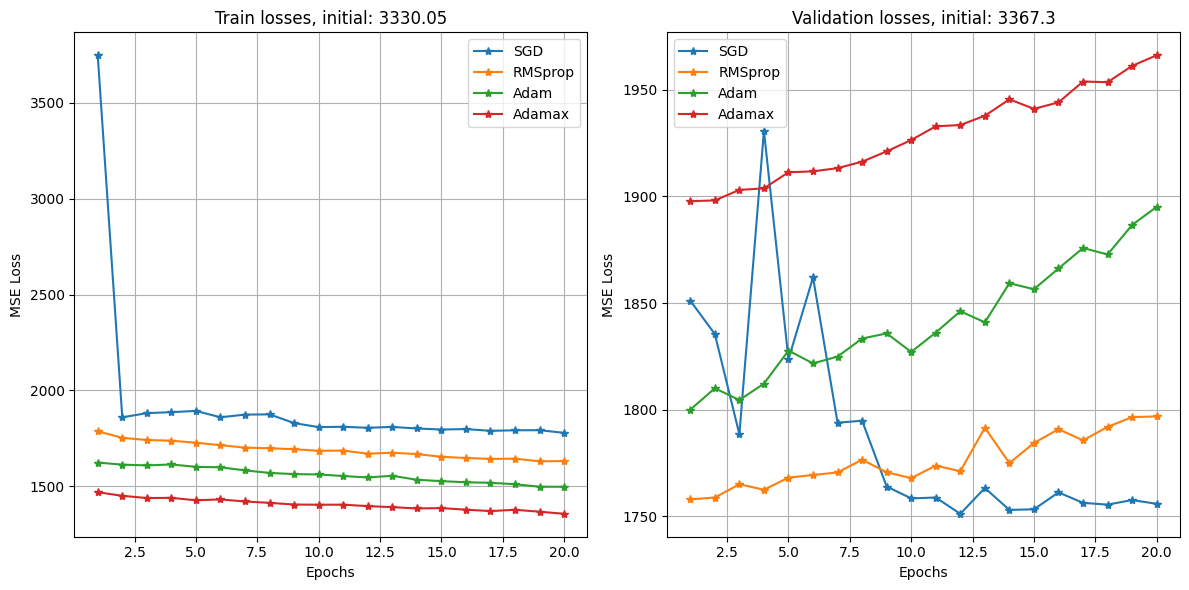

In [14]:
# Plot
plot_dictionaries(
    train_loss_dict,
    val_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_testing.png",
)

### So for full training we will take SGD, 20 layers with 256 neurouns in each and lr=4e-7

In [27]:
N_EPOCH = 50
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 3e-5
HIDDEN_LAYER = 50
HIDDEN_WIDTH = 64
EXPERIMENT_NAME = "exp_call_8_gen"
MODEL_TYPE = AmericanPut_gated3
experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [28]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [30]:
df

,TimeToExp,UnderlyingPrice,TargetPrice,OpenInterest,Delta,Gamma,Theta,Vega,BSAprox
0,850.00,122.12,43.00,364.0,0.345992,0.144298,-3.575622,2.522842,31.500
1,311.00,186.19,29.31,514.0,0.167115,0.056784,-2.531811,6.822075,24.655
2,629.00,52.52,69.69,65.0,0.376269,0.272558,-7.814967,5.852912,0.000
3,469.00,144.80,37.75,58.0,0.009575,0.017516,-1.451383,1.604901,0.000
4,0.00,187.07,29.12,91.0,0.441506,0.138325,-8.777276,5.934998,118.970
...,...,...,...,...,...,...,...,...,...
9995,1089.04,200.00,200.00,54.0,0.189853,0.083916,-31.967621,3.605873,82.030
9996,939.78,200.00,200.00,410.0,0.034537,0.091283,-10.788996,6.799438,82.030
9997,886.42,200.00,200.00,274.0,0.015381,0.324230,-4.528091,7.367978,82.030
9998,560.18,200.00,200.00,586.0,0.275679,0.402972,-4.144945,3.066105,82.030


In [31]:
df_train, df_test = train_test_split(df, test_size=0.2)
logging.info(f"train set size: {df_train.shape}")
logging.info(f"test set size: {df_test.shape}")
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = (
    1 / len(df_test) * np.sum((df_test.TargetPrice - df_test.BSAprox) ** 2)
)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)
train_df = CustomDataset(df_train)
test_df = CustomDataset(df_test)

In [32]:
# import torch.multiprocessing as mp
from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Set the multiprocessing start method to 'spawn'
# mp.set_start_method("spawn", force=True)
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    test_df,
    batch_size=64,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "SGD": torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.7),
}
# criteriation = nn.MSELoss()
# # Set the multiprocessing start method to 'spawn'
# mp.set_start_method("spawn", force=True)
# model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)

In [33]:
train_loss_dict = {}
test_loss_dict = {}
train_cycle("SGD", optimizers_list["SGD"], train_loss_dict, test_loss_dict)

Optimizer: SGD


100%|██████████| 32/32 [00:00<00:00, 163.12it/s]


Epoch 1, train loss: 1860.6847, test loss: 1910.6102


100%|██████████| 32/32 [00:00<00:00, 165.78it/s]

Epoch 2, train loss: 1789.2217, test loss: 1953.9997



100%|██████████| 32/32 [00:00<00:00, 119.17it/s]

Epoch 3, train loss: 1793.2629, test loss: 1911.4333



100%|██████████| 32/32 [00:00<00:00, 136.10it/s]

Epoch 4, train loss: 1797.5282, test loss: 1914.1728



100%|██████████| 32/32 [00:00<00:00, 127.54it/s]

Epoch 5, train loss: 1787.7645, test loss: 1915.6909



100%|██████████| 32/32 [00:00<00:00, 143.66it/s]

Epoch 6, train loss: 1791.9267, test loss: 1910.9990



100%|██████████| 32/32 [00:00<00:00, 130.91it/s]

Epoch 7, train loss: 1787.8529, test loss: 1936.1527



100%|██████████| 32/32 [00:00<00:00, 160.42it/s]

Epoch 8, train loss: 1787.1684, test loss: 1912.7816



100%|██████████| 32/32 [00:00<00:00, 151.43it/s]

Epoch 9, train loss: 1785.7555, test loss: 1911.8429



100%|██████████| 32/32 [00:00<00:00, 151.76it/s]

Epoch 10, train loss: 1787.7884, test loss: 1916.7225



100%|██████████| 32/32 [00:00<00:00, 115.60it/s]

Epoch 11, train loss: 1784.8655, test loss: 1912.4627



100%|██████████| 32/32 [00:00<00:00, 159.45it/s]

Epoch 12, train loss: 1785.9713, test loss: 1917.5330



100%|██████████| 32/32 [00:00<00:00, 160.65it/s]

Epoch 13, train loss: 1787.1268, test loss: 1913.8998



100%|██████████| 32/32 [00:00<00:00, 156.00it/s]

Epoch 14, train loss: 1784.4453, test loss: 1912.9105



100%|██████████| 32/32 [00:00<00:00, 170.18it/s]

Epoch 15, train loss: 1783.8293, test loss: 1913.1841



100%|██████████| 32/32 [00:00<00:00, 158.33it/s]

Epoch 16, train loss: 1784.9382, test loss: 1916.2510



100%|██████████| 32/32 [00:00<00:00, 157.72it/s]

Epoch 17, train loss: 1782.0666, test loss: 1927.8300



100%|██████████| 32/32 [00:00<00:00, 174.72it/s]

Epoch 18, train loss: 1786.0605, test loss: 1921.2585



100%|██████████| 32/32 [00:00<00:00, 170.80it/s]

Epoch 19, train loss: 1783.6833, test loss: 1917.4883



100%|██████████| 32/32 [00:00<00:00, 167.77it/s]

Epoch 20, train loss: 1783.2330, test loss: 1914.1939



100%|██████████| 32/32 [00:00<00:00, 157.70it/s]

Epoch 21, train loss: 1783.7198, test loss: 1919.9071



100%|██████████| 32/32 [00:00<00:00, 169.76it/s]

Epoch 22, train loss: 1782.7713, test loss: 1919.9515



100%|██████████| 125/125 [00:01<00:00, 81.64it/s]

Epoch 00023: reducing learning rate of group 0 to 3.0000e-06.



100%|██████████| 32/32 [00:00<00:00, 151.89it/s]

Epoch 23, train loss: 1790.2206, test loss: 1920.1964



100%|██████████| 32/32 [00:00<00:00, 159.82it/s]

Epoch 24, train loss: 1778.2833, test loss: 1913.4609



100%|██████████| 32/32 [00:00<00:00, 176.88it/s]

Epoch 25, train loss: 1777.9068, test loss: 1913.6995



100%|██████████| 32/32 [00:00<00:00, 169.33it/s]

Epoch 26, train loss: 1777.7269, test loss: 1913.7575



100%|██████████| 32/32 [00:00<00:00, 177.62it/s]

Epoch 27, train loss: 1778.1664, test loss: 1913.9387



100%|██████████| 32/32 [00:00<00:00, 172.04it/s]

Epoch 28, train loss: 1777.8395, test loss: 1914.1153



100%|██████████| 32/32 [00:00<00:00, 177.52it/s]

Epoch 29, train loss: 1777.7945, test loss: 1914.3630



100%|██████████| 32/32 [00:00<00:00, 171.11it/s]

Epoch 30, train loss: 1777.6664, test loss: 1914.7065



100%|██████████| 32/32 [00:00<00:00, 171.65it/s]

Epoch 31, train loss: 1777.7703, test loss: 1914.4857



100%|██████████| 125/125 [00:01<00:00, 82.93it/s]

Epoch 00032: reducing learning rate of group 0 to 3.0000e-07.



100%|██████████| 32/32 [00:00<00:00, 176.49it/s]

Epoch 32, train loss: 1777.8768, test loss: 1914.9711



100%|██████████| 32/32 [00:00<00:00, 180.54it/s]

Epoch 33, train loss: 1777.3310, test loss: 1914.5801



100%|██████████| 32/32 [00:00<00:00, 162.15it/s]


Epoch 34, train loss: 1776.9110, test loss: 1914.4984


100%|██████████| 32/32 [00:00<00:00, 172.79it/s]

Epoch 35, train loss: 1776.7938, test loss: 1914.5293



100%|██████████| 32/32 [00:00<00:00, 168.01it/s]

Epoch 36, train loss: 1776.7564, test loss: 1914.5607



100%|██████████| 32/32 [00:00<00:00, 159.71it/s]

Epoch 37, train loss: 1776.8068, test loss: 1914.6165



100%|██████████| 32/32 [00:00<00:00, 176.04it/s]

Epoch 38, train loss: 1776.7302, test loss: 1914.6196



100%|██████████| 32/32 [00:00<00:00, 160.78it/s]

Epoch 39, train loss: 1776.7324, test loss: 1914.6827



100%|██████████| 32/32 [00:00<00:00, 176.09it/s]

Epoch 40, train loss: 1776.7918, test loss: 1914.6887



100%|██████████| 32/32 [00:00<00:00, 165.01it/s]

Epoch 41, train loss: 1776.7148, test loss: 1914.6936



100%|██████████| 32/32 [00:00<00:00, 174.17it/s]

Epoch 42, train loss: 1776.7004, test loss: 1914.7154



100%|██████████| 32/32 [00:00<00:00, 158.37it/s]

Epoch 43, train loss: 1776.7042, test loss: 1914.7707



100%|██████████| 125/125 [00:01<00:00, 79.57it/s]

Epoch 00044: reducing learning rate of group 0 to 3.0000e-08.



100%|██████████| 32/32 [00:00<00:00, 164.70it/s]

Epoch 44, train loss: 1776.6900, test loss: 1914.7794



100%|██████████| 32/32 [00:00<00:00, 183.66it/s]

Epoch 45, train loss: 1776.5871, test loss: 1914.7814



100%|██████████| 32/32 [00:00<00:00, 181.19it/s]

Epoch 46, train loss: 1776.5829, test loss: 1914.7817



100%|██████████| 32/32 [00:00<00:00, 154.58it/s]

Epoch 47, train loss: 1776.5775, test loss: 1914.7836



100%|██████████| 32/32 [00:00<00:00, 151.32it/s]

Epoch 48, train loss: 1776.5864, test loss: 1914.7864



100%|██████████| 32/32 [00:00<00:00, 164.71it/s]


Epoch 49, train loss: 1776.5755, test loss: 1914.7868


100%|██████████| 125/125 [00:01<00:00, 81.09it/s]

Epoch 00050: reducing learning rate of group 0 to 3.0000e-09.



100%|██████████| 32/32 [00:00<00:00, 167.90it/s]

Epoch 50, train loss: 1776.5779, test loss: 1914.7862


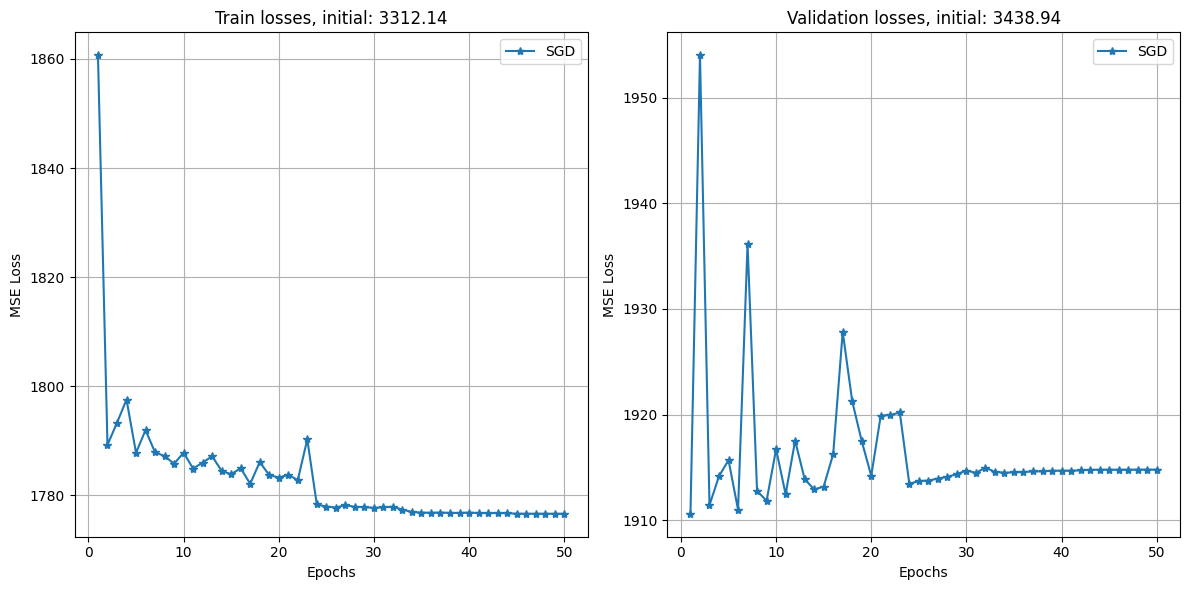

In [34]:
plot_dictionaries(
    train_loss_dict,
    test_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_final.png",
)

In [35]:
import json

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_train.json"
with open(file_path, "w") as json_file:
    json.dump(train_loss_dict, json_file)

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_test.json"
with open(file_path, "w") as json_file:
    json.dump(test_loss_dict, json_file)

In [37]:
logging.info(
    f"% of variation before training: {(initial_mse_train/(df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(train_loss_dict['SGD'][20]/ (df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation before training: {(initial_mse_val/(df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(test_loss_dict['SGD'][20] / (df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)